# Bidirection Compression
https://github.com/aigoncharov/ml-bidirection-compression

## Problem statement

The main problem is that the server still sends non-compressed vectors xk to the workers. 
"K. Gruntkowska, A. Tyurin, and P. Richtarik. EF21-P and friends: Improved theoretical communication complexity for distributed optimization with bidirectional compression. In International Conference on Machine Learning, pages 11761–11807. PMLR, 2023." proposed a new strategy called EF21-P to compress information from the server to the workers. 
In this project, we implement the main methods from it (DIANA, DCGD) and compare them.

## 1. Implement an environment that would emulate the communication of workers with the server


In [30]:
import time
import numpy as np
from sklearn.utils import gen_batches
import abc
from dataclasses import dataclass
from typing import List


class Compressor(metaclass=abc.ABCMeta):
    def __init__(self, compression_ratio):
        self.compression_ratio = compression_ratio
        self.transmitted_coordinates = 0

    @abc.abstractmethod
    def compress(self, gradient_device):
        pass

    def decompress(self, gradient_device, selected_indices, original_size):
        decompressed = np.zeros(original_size)
        decompressed[selected_indices] = gradient_device
        return decompressed

    def omega(self, gradient_device):
        k = max(1, int(len(gradient_device) * self.compression_ratio))
        return len(gradient_device) / k - 1


class Device:
    def __init__(
        self,
        env,
        n_features,
    ):
        self.n_features = n_features
        self.weights = np.zeros(n_features)
        self.env = env

    def execute(self, X, y, L, n_devices, iteration):
        lambda_reg = L / 1000
        gradient_device = self.env.nabla_f(X, y, self.weights, lambda_reg)

        gamma = self.env.gamma_k(L, self.env.compressor.omega(gradient_device), n_devices, iteration)
        self.weights -= gamma * gradient_device

        compressed_gradient, indices = self.env.compressor.compress(gradient_device)

        return compressed_gradient, indices


@dataclass
class SimulationState:
    X: np.ndarray
    y: np.ndarray
    X_split: np.ndarray
    y_split: np.ndarray
    n_features: int
    n_devices: int
    eps: float | None
    weights: np.ndarray
    devices: List[Device]
    convergence: List[float]
    accuracies: List[float]
    execution_time: float
    L: float
    transmitted_coordinates: List[int]


class DistributedEnvSimulator:
    def __init__(self, nabla_f, gamma_k, compressor):
        self.nabla_f = nabla_f
        self.gamma_k = gamma_k
        self.compressor = compressor

    def simulate_distributed_env(
        self,
        X,
        y,
        n_devices,
        num_iterations=100,
        eps=None,
    ):
        X_split, y_split = self._split_data(X, y, int(X.shape[0] / n_devices))
        state = self._init_simulation_state(X, y, X_split, y_split, n_devices, eps)

        for iteration in range(num_iterations):
            eps_achieved = self._run_iteration(state, iteration)

            if eps_achieved:
                break

        return state

    def _run_iteration(self, state, iteration):
        start_time = time.time()
        device_updates = []

        for device_idx in range(state.n_devices):
            device_updates.append(self._run_on_device(state, device_idx, iteration))

        aggregated_res = self._aggregate_iteration(state, device_updates, iteration)

        state.execution_time += time.time() - start_time

        eps_achieved = self._estimate_iteration(state, aggregated_res)
        return eps_achieved

    def _estimate_iteration(self, state, iteration_res):
        (iteration_gradient, gamma) = iteration_res
        accuracy_i = self._estimate_accuracy(state.X, state.y, state.weights)
        state.accuracies.append(accuracy_i)
        convergence_i = self._estimate_convergence(iteration_gradient, state.n_devices)
        state.convergence.append(convergence_i)

        if state.eps is not None and accuracy_i < state.eps:
            return True

        return False

    def _aggregate_iteration(self, state, device_updates, iteration):
        aggregated_gradient = np.zeros(state.n_features)
        for device_update in device_updates:
            aggregated_gradient += device_update

        gamma = self.gamma_k(state.L, self.compressor.omega(aggregated_gradient), state.n_devices, iteration)
        state.weights -= gamma * (aggregated_gradient / state.n_devices)

        state.transmitted_coordinates.append(self.compressor.transmitted_coordinates)

        return aggregated_gradient, gamma

    def _run_on_device(self, state, device_idx, iteration):
        batch_idx = np.random.randint(0, state.n_devices)

        X_device = state.X_split[batch_idx]
        y_device = state.y_split[batch_idx]
        device = state.devices[device_idx]

        compressed_update, indices = device.execute(X_device, y_device, state.L, state.n_devices, iteration)

        device_update = self.compressor.decompress(compressed_update, indices, state.n_features)
        return device_update

    def _init_simulation_state(self, X, y, X_split, y_split, n_devices, eps):
        n_features = X.shape[1]
        weights = np.zeros(n_features)
        devices = [self._create_device(self, n_features) for _ in range(n_devices)]
        convergence = []
        accuracies = []
        execution_time = 0
        transmitted_coordinates = []

        L = np.sum(np.linalg.vector_norm(X, axis=1) ** 2) / (4 * X.shape[1])

        return SimulationState(
            X,
            y,
            X_split,
            y_split,
            n_features,
            n_devices,
            eps,
            weights,
            devices,
            convergence,
            accuracies,
            execution_time,
            L,
            transmitted_coordinates,
        )

    def _estimate_accuracy(self, X, y, weights):
        y_pred = np.sign(np.dot(X, weights))
        diff = y.astype("int") - y_pred.astype("int")
        false_predictions = len(diff[diff != 0])
        accuracy = 1 - false_predictions / len(y_pred)
        return accuracy

    def _estimate_convergence(self, aggregated_gradient, n_devices):
        return np.linalg.norm(aggregated_gradient / n_devices)

    def _create_device(self, *args):
        return Device(*args)

    def _split_data(self, X, y, batch_size):
        X_batched = []
        y_batched = []
        for batch_indices in gen_batches(n=len(X), batch_size=batch_size, min_batch_size=batch_size):
            X_batched.append(X[batch_indices])
            y_batched.append(y[batch_indices])
        return X_batched, y_batched

## 2. Implement CGD


In [31]:
class RandKCompressor(Compressor):
    def compress(self, vector):
        k = max(1, int(len(vector) * self.compression_ratio))

        selected_indices = np.random.choice(len(vector), size=k, replace=False)

        compressed = np.zeros(len(selected_indices))
        compressed = vector[selected_indices]

        self.transmitted_coordinates += len(compressed)

        return compressed, selected_indices

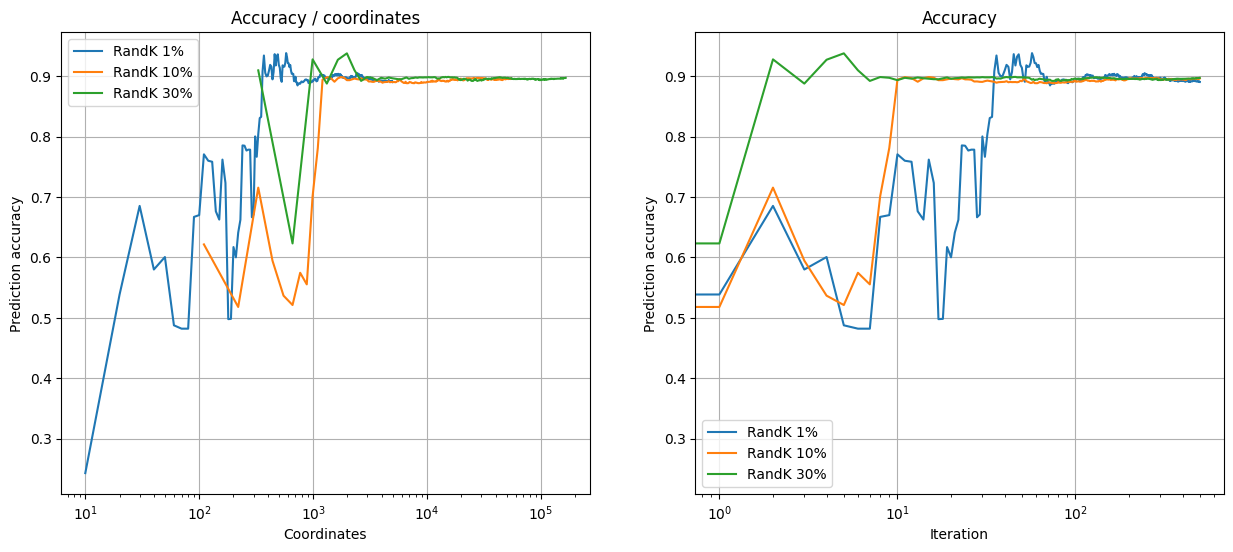

In [32]:
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))

for ratio in compression_ratios:
    randk_compressor = RandKCompressor(ratio)
    randk_simulator = DistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        compressor=randk_compressor,
    )
    randk_res = randk_simulator.simulate_distributed_env(
        X=X,
        y=y,
        n_devices=n_devices,
        num_iterations=num_iterations,
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        randk_res.transmitted_coordinates,
        randk_res.accuracies,
        label=f"RandK {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(randk_res.accuracies, label=f"RandK {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Prediction accuracy")
plt.xlabel("Coordinates")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title("Accuracy / coordinates")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()

## 3. EF21-P + DIANA


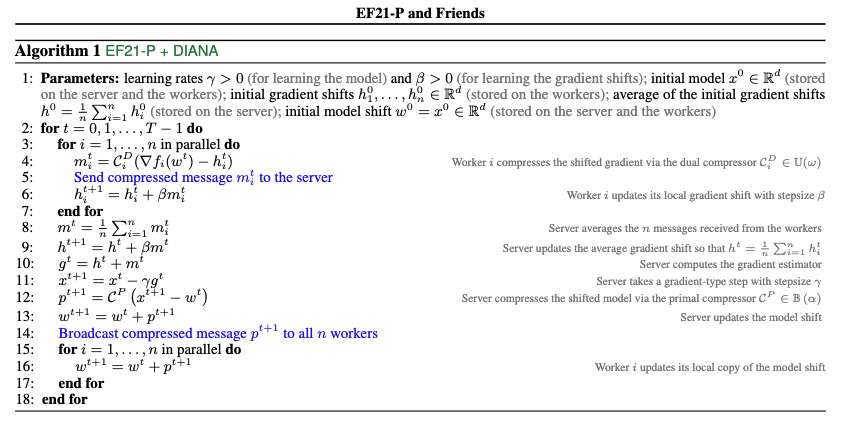

In [33]:
import dataclasses


class DianaDevice(Device):
    def __init__(self, env, n_features):
        super().__init__(env, n_features)

        self.error_feedback = np.zeros(n_features)
        self.h = np.zeros(n_features)

    def execute(self, X, y, L, n_devices, iteration):
        lambda_reg = L / 1000
        gradient_device = self.env.nabla_f(X, y, self.weights, lambda_reg)

        gradient_with_error = gradient_device + self.error_feedback
        compressed_gradient, indices = self.env.compressor.compress(gradient_with_error)

        decompressed = self.env.compressor.decompress(compressed_gradient, indices, self.n_features)

        self.error_feedback = gradient_with_error - decompressed
        self.h = self.h + decompressed

        gamma = self.env.gamma_k(L, self.env.compressor.omega(gradient_device), n_devices, iteration)
        self.weights -= gamma * (gradient_device + self.error_feedback)

        return compressed_gradient, indices


@dataclass
class DianaSimulationState(SimulationState):
    server_h: np.ndarray


class DianaDistributedEnvSimulator(DistributedEnvSimulator):
    def _create_device(self, *args):
        return DianaDevice(*args)

    def _init_simulation_state(self, X, y, X_split, y_split, n_devices, eps):
        super_state = super()._init_simulation_state(X, y, X_split, y_split, n_devices, eps)
        server_h = np.zeros(super_state.n_features)
        return DianaSimulationState(**dataclasses.asdict(super_state), server_h=server_h)

    def _aggregate_iteration(self, state, device_updates, iteration):
        aggregated_update = np.zeros(state.n_features)
        for device_update in device_updates:
            aggregated_update += device_update
        aggregated_update /= state.n_devices

        state.server_h += aggregated_update

        gamma = self.gamma_k(state.L, self.compressor.omega(aggregated_update), state.n_devices, iteration)
        state.weights -= gamma * state.server_h

        state.transmitted_coordinates.append(self.compressor.transmitted_coordinates)

        return state.server_h, gamma

    def _broadcast(self, state, iteration_res):
        (iteration_update, gamma) = iteration_res
        # TODO: Add a separate server_to_worker compressor
        compressed_shift, shift_indices = self.compressor.compress(gamma * state.server_h)
        for device in state.devices:
            decompressed_shift = self.compressor.decompress(compressed_shift, shift_indices, state.n_features)
            device.weights -= decompressed_shift

    def _run_iteration(self, state, iteration):
        start_time = time.time()
        device_updates = []

        for device_idx in range(state.n_devices):
            device_updates.append(self._run_on_device(state, device_idx, iteration))

        iteration_res = self._aggregate_iteration(state, device_updates, iteration)
        self._broadcast(state, iteration_res)

        state.execution_time += time.time() - start_time

        eps_achieved = self._estimate_iteration(state, iteration_res)
        return eps_achieved

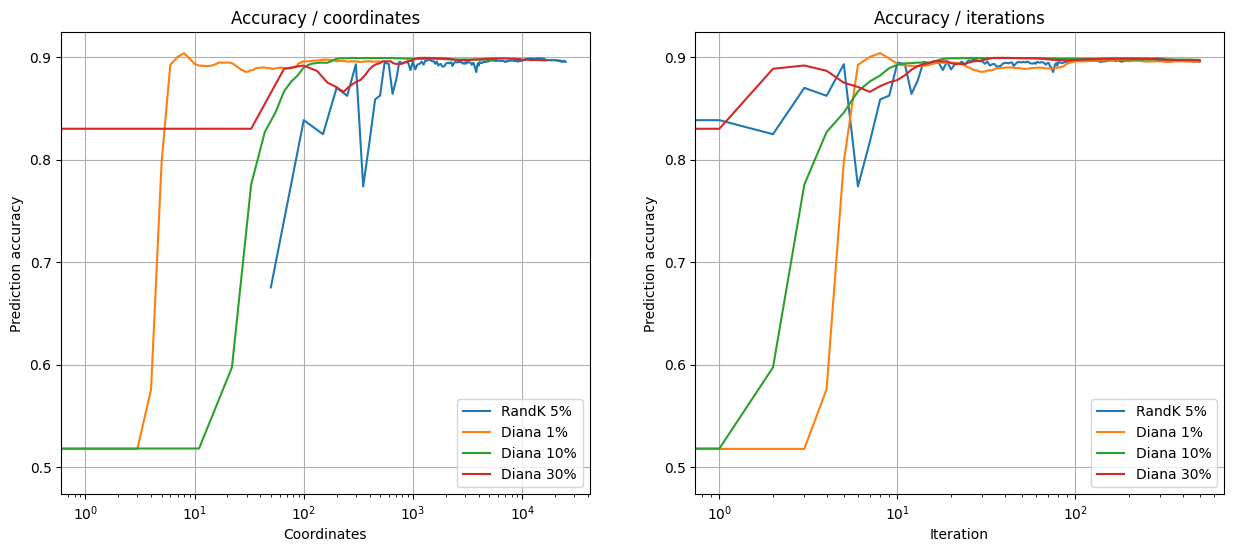

In [34]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
ref_compression_ratio = 0.05
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))


randk_compressor = RandKCompressor(ref_compression_ratio)
randk_simulator = DistributedEnvSimulator(
    nabla_f=nabla_f,
    gamma_k=gamma_k,
    compressor=randk_compressor,
)
randk_res = randk_simulator.simulate_distributed_env(
    X=X,
    y=y,
    n_devices=n_devices,
    num_iterations=num_iterations,
)
plt.subplot(1, 2, 1)
plt.plot(
    randk_res.transmitted_coordinates,
    randk_res.accuracies,
    label=f"RandK {int(ref_compression_ratio*100)}%",
)

plt.subplot(1, 2, 2)
plt.plot(np.array(randk_res.accuracies), label=f"RandK {int(ref_compression_ratio*100)}%")

for ratio in compression_ratios:
    randk_compressor = RandKCompressor(ratio)
    diana_simulator = DianaDistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        compressor=randk_compressor,
    )
    diana_res = diana_simulator.simulate_distributed_env(
        X=X, y=y, n_devices=n_devices, num_iterations=num_iterations, eps=None
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        diana_res.transmitted_coordinates,
        diana_res.accuracies,
        label=f"Diana {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(diana_res.accuracies, label=f"Diana {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Prediction accuracy")
plt.xlabel("Coordinates")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title("Accuracy / coordinates")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title("Accuracy / iterations")

plt.show()

## EF21-P + DGCD


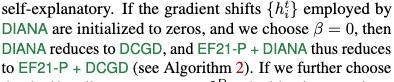

In [35]:
class DCGDDevice(DianaDevice):
    def __init__(self, env, n_features):
        super().__init__(env, n_features)

        self.error_feedback = np.zeros(n_features)
        self.h = np.zeros(n_features)

    def execute(self, X, y, L, n_devices, iteration):
        lambda_reg = L / 1000
        gradient_device = self.env.nabla_f(X, y, self.weights, lambda_reg)

        gradient_with_error = gradient_device + self.error_feedback
        compressed_gradient, indices = self.env.compressor.compress(gradient_with_error)

        return compressed_gradient, indices


class DCGDDistributedEnvSimulator(DianaDistributedEnvSimulator):
    def _create_device(self, *args):
        return DCGDDevice(*args)

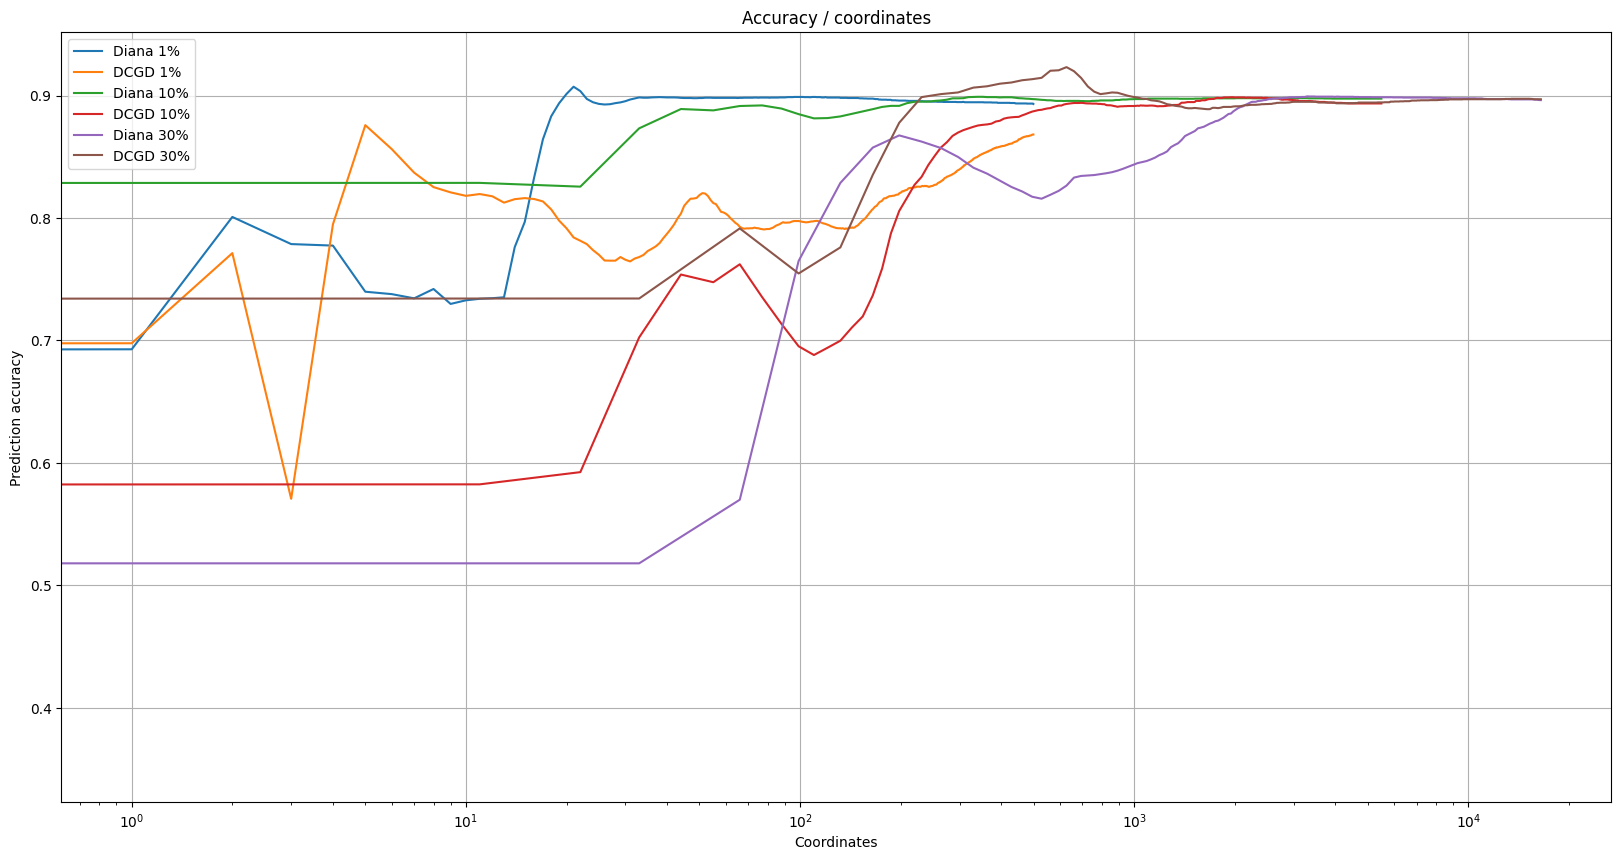

In [37]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(20, 10))

for ratio in compression_ratios:
    randk_compressor = RandKCompressor(ratio)
    diana_simulator = DianaDistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        compressor=randk_compressor,
    )
    diana_res = diana_simulator.simulate_distributed_env(
        X=X, y=y, n_devices=n_devices, num_iterations=num_iterations, eps=None
    )

    randk_compressor = RandKCompressor(ratio)
    dcgd_simulator = DCGDDistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        compressor=randk_compressor,
    )
    dcgd_res = dcgd_simulator.simulate_distributed_env(
        X=X, y=y, n_devices=n_devices, num_iterations=num_iterations, eps=None
    )

    plt.plot(diana_res.transmitted_coordinates, diana_res.accuracies, label=f"Diana {int(ratio*100)}%")
    plt.plot(dcgd_res.transmitted_coordinates, dcgd_res.accuracies, label=f"DCGD {int(ratio*100)}%")

plt.xlabel("Coordinates")
plt.ylabel("Prediction accuracy")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title("Accuracy / coordinates")

plt.show()

## Results

We implemented CGD, DIANA and DCGD methods and compared them for the sigmoid loss problem. As expected, DIANA provides the best performance in regard to the number of transmitted coordinates.